# E6. kaggle competition 집값 예측하기!

https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/data 해당 캐글 대회에서 제공하는 "집값 관련 데이터"를 학습하고, 집값을 예측하는 실습입니다.

#### 실습 목차
1. Data load & Preprocess
2. EDA & Feature engineering
3. Model Training
4. Retrospective

## 1. Data load & Preprocess

In [1]:
!ls

drive  sample_data


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats

import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_dir = '/content/drive/MyDrive/data_colab/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
# train, sub 데이터프레임 통합
train_len = len(train)
data = pd.concat((train, sub))
print(train_len)

15035


In [6]:
# date 열 전처리
data['date'] = data['date'].apply(lambda i: i[:8]).astype(int)

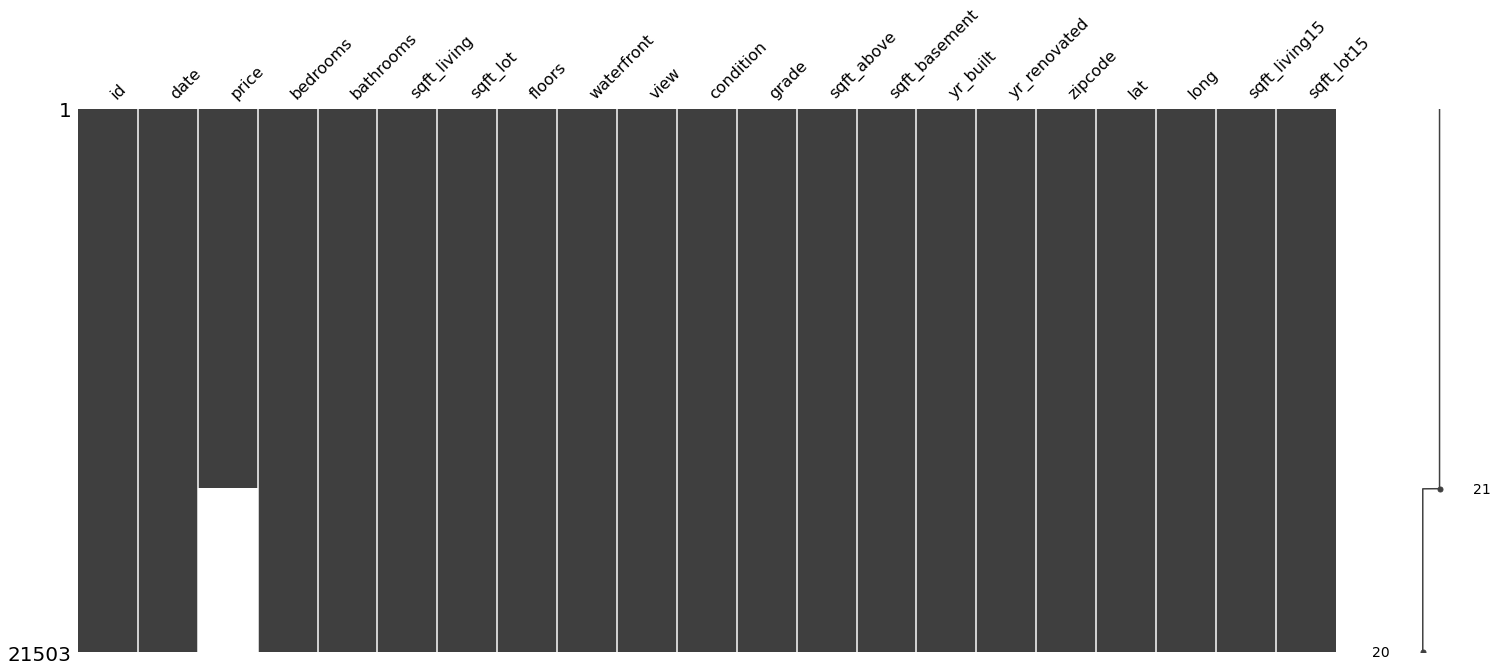

In [7]:
# 결측치 확인
msno.matrix(data)

## 2. EDA & Feature Engineering

- EDA 에서 많은 부분 https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12 해당 커널을 참고하였습니다.

In [8]:
data.shape

(21503, 21)

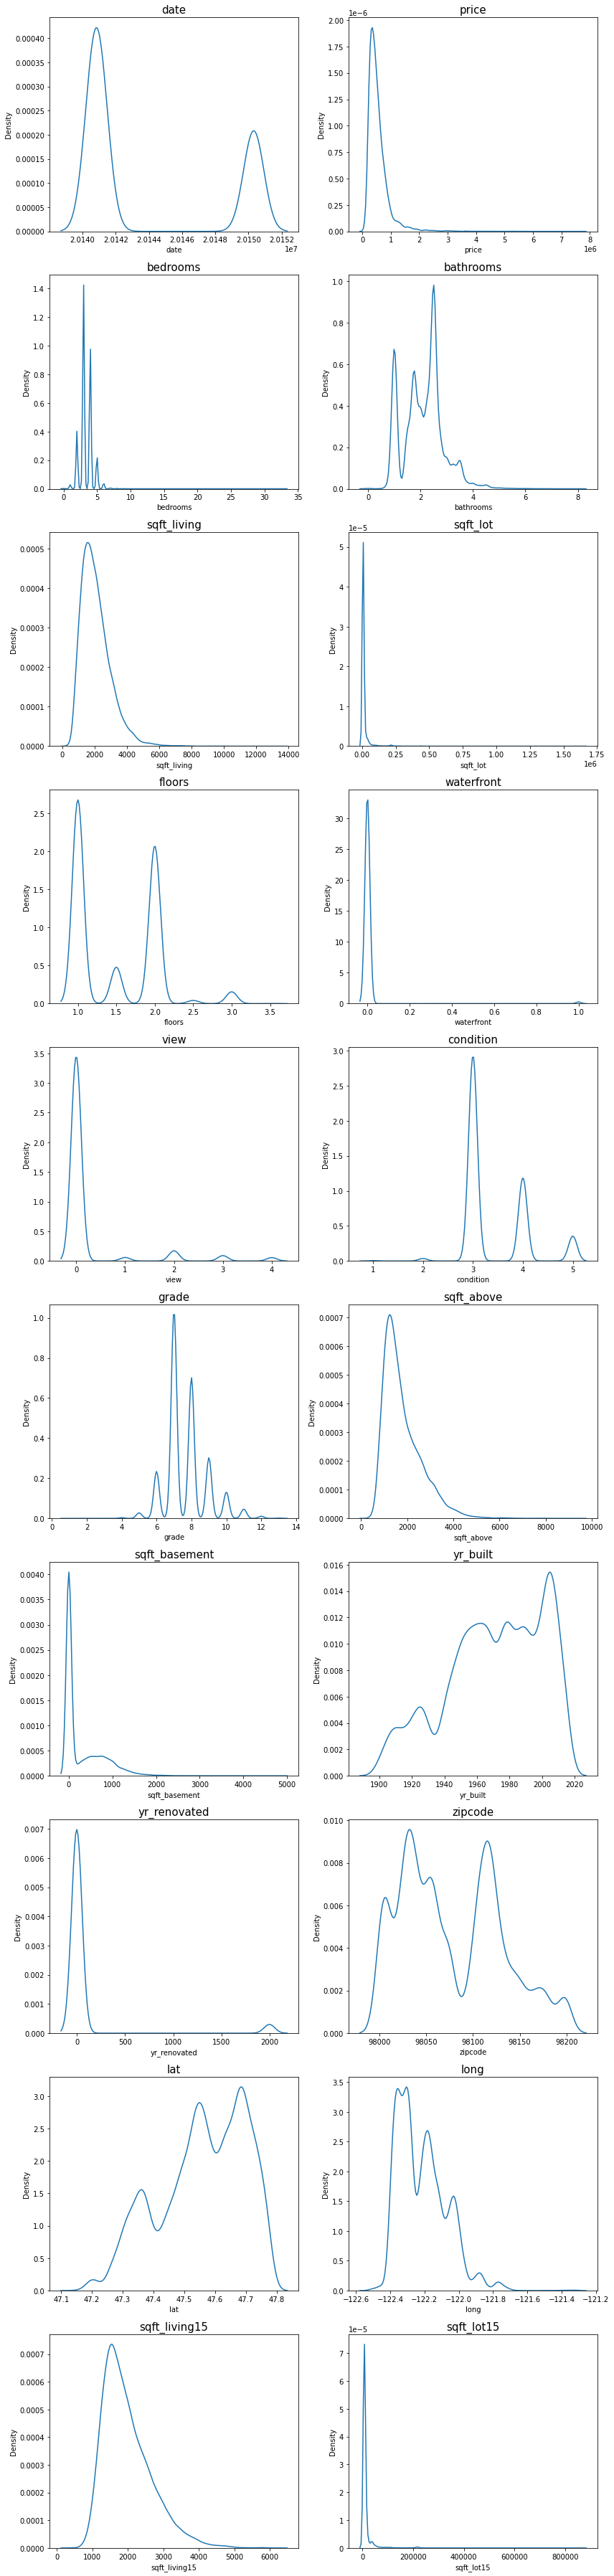

In [9]:
# 각 변수들의 분포 확인
fig, ax = plt.subplots(10,2,figsize=(12,50))

count=1
columns = data.columns
for row in range(10):
  for col in range(2):
    sns.kdeplot(data[columns[count]], ax = ax[row][col])
    ax[row][col].set_title(columns[count], fontsize=15)
    count+=1
    if count == 21:
      break

plt.tight_layout()

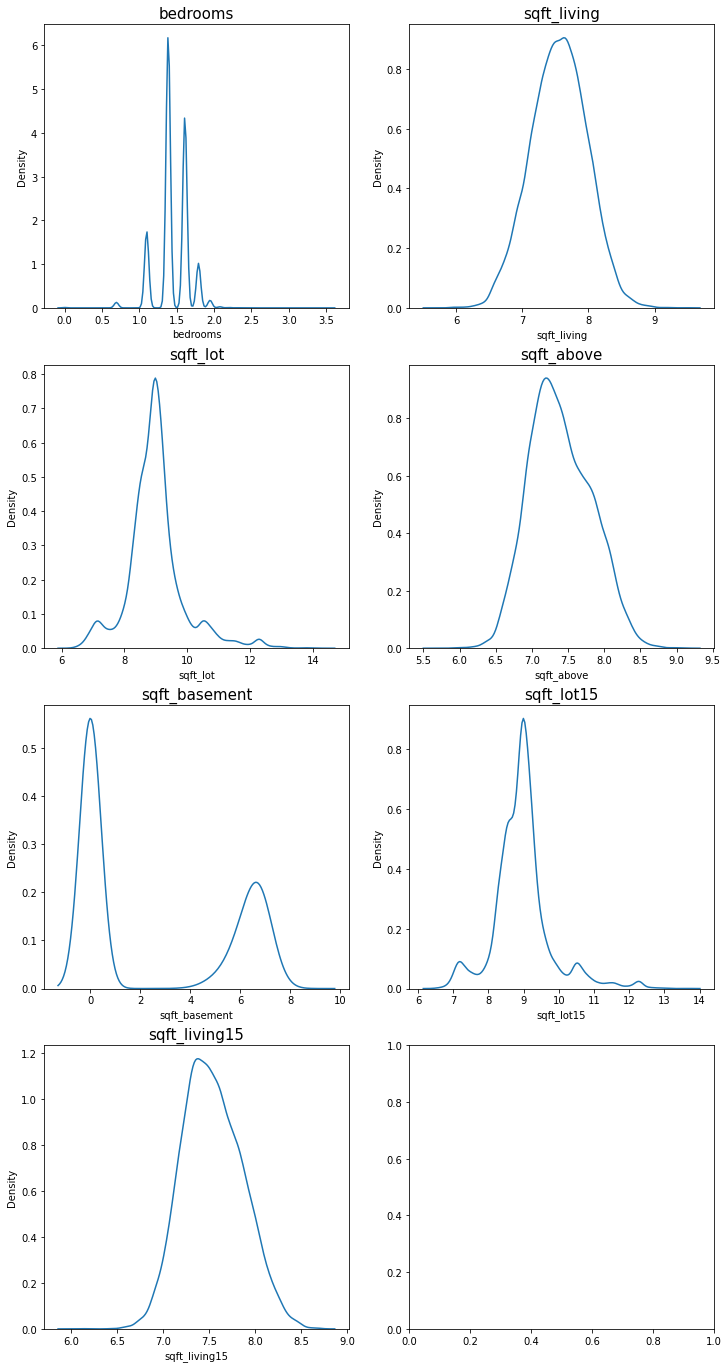

In [10]:
# 치우친 분포를 log 변환
skew_columns = ['bedrooms', 'sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_lot15','sqft_living15']

for c in skew_columns:
  data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(4,2,figsize=(12,24))

count=0
for row in range(4):
  for col in range(2):
    if count == 7: break
    sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
    ax[row][col].set_title(skew_columns[count],fontsize=15)
    count+=1

In [11]:
# train, sub 데이터셋으로 분리
train = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]
del sub['price']

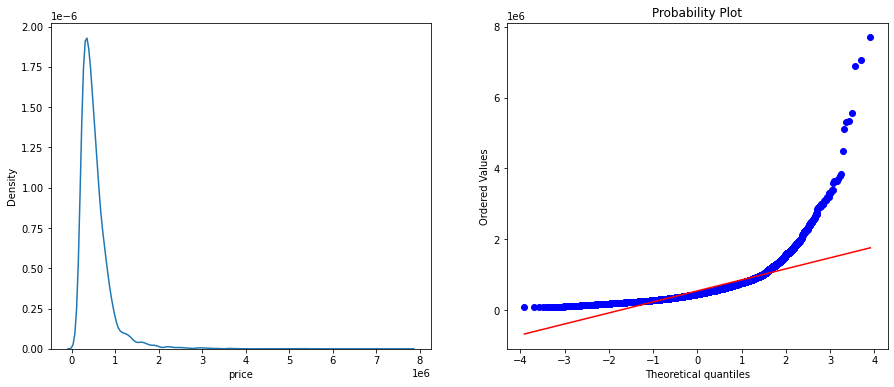

In [12]:
# target data인 가격 분포 확인
fig = plt.figure(figsize=(15,6))

fig.add_subplot(1,2,1)
sns.kdeplot(train['price'])

fig.add_subplot(1,2,2)
res = stats.probplot(train['price'], plot=plt)

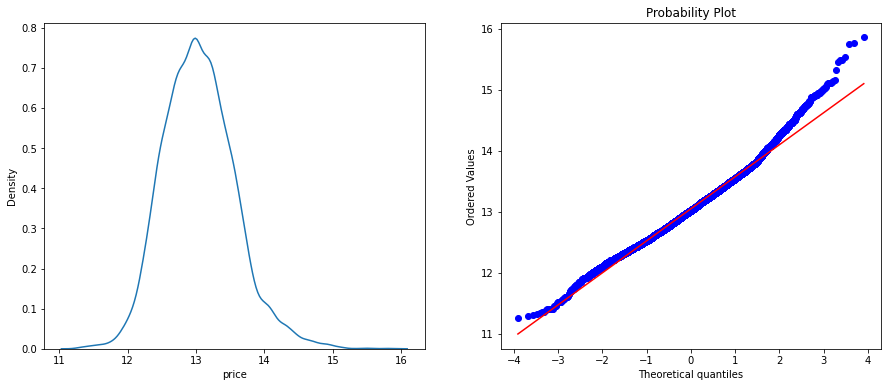

In [13]:
# train['price'] 로그변환
train['price'] = np.log1p(train['price'])

fig = plt.figure(figsize=(15,6))

fig.add_subplot(1,2,1)
sns.kdeplot(train['price'])

fig.add_subplot(1,2,2)
res = stats.probplot(train['price'], plot=plt)

plt.show()


['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


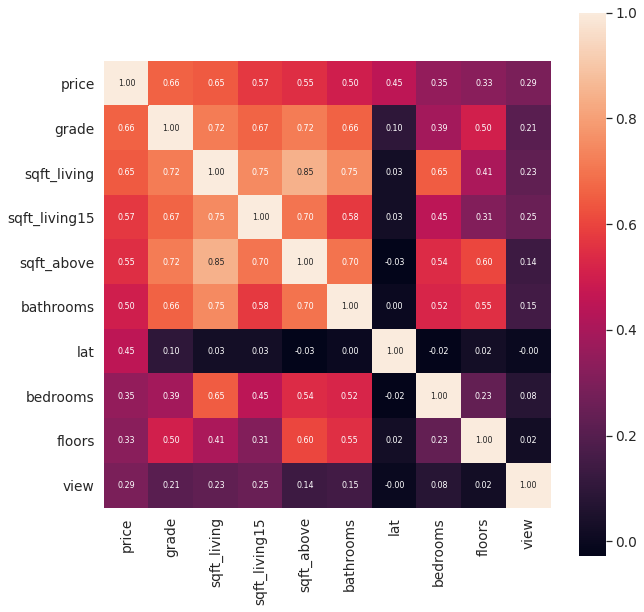

In [14]:
# 변수들의 상관관계 시각화
# price와 상관관계가 높은 상위 10개 변수들만 표현
cor_abs = abs(train.corr(method='spearman'))
cor_cols = cor_abs.nlargest(n=10, columns='price').index

cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0]
print(cor_cols.values)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f',annot=True,square=True,annot_kws={'size' : 8},
            xticklabels=cor_cols.values,
            yticklabels=cor_cols.values)

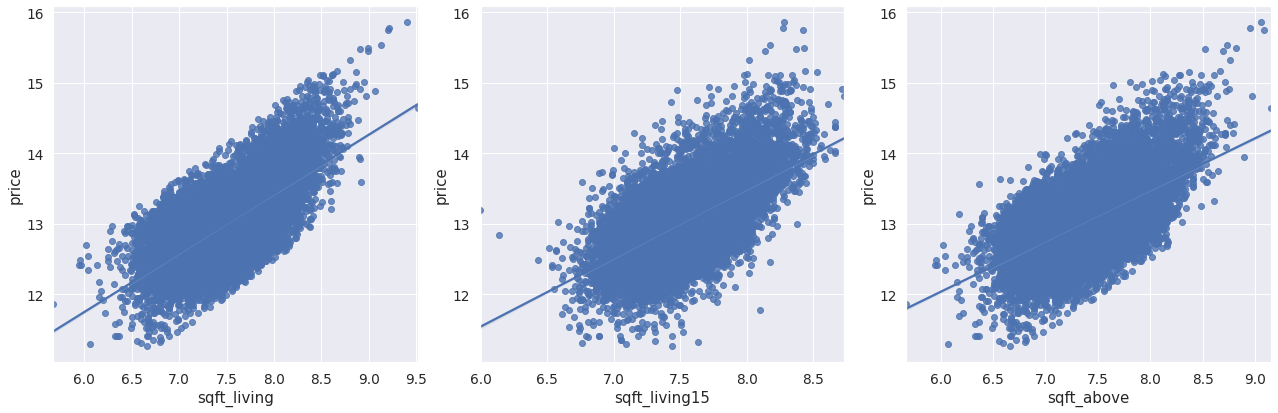

In [15]:
f = plt.figure(figsize=(18, 6))

f.add_subplot(131)
sns.regplot(x=train['sqft_living'], y=train['price'])

f.add_subplot(132)
sns.regplot(x=train['sqft_living15'], y=train['price'])

f.add_subplot(133)
sns.regplot(x=train['sqft_above'], y=train['price'])

plt.tight_layout()
plt.show()

In [42]:
train.loc[train['sqft_living'] > 9.0]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_ratio15,sqft_total_size,is_renovated
2775,20140611,1.791759,4.50,9.214432,10.527445,2.0,1,2,3,11,8.946505,7.766841,1940,2001,98004,47.6500,-122.214,8.276649,10.144471,6.291759,0.875277,0.815878,16.713346,1
3134,20140804,1.791759,5.75,9.127067,10.465101,2.0,0,0,3,13,8.732466,8.006701,2001,0,98039,47.6289,-122.233,8.177797,10.100123,7.541759,0.872143,0.809673,16.739167,0
5108,20141013,1.945910,8.00,9.396903,10.225607,2.5,0,3,4,13,9.056140,8.155075,1910,1987,98102,47.6298,-122.323,8.279190,9.082621,9.945910,0.918958,0.911542,17.211215,1
6469,20140919,1.945910,7.75,9.199381,10.353767,2.0,0,4,3,13,9.089415,6.938284,2001,0,98039,47.6305,-122.240,8.420903,10.662680,9.695910,0.888506,0.789755,16.027699,0
10152,20140611,1.791759,6.25,9.067739,11.067169,2.0,0,4,3,13,8.719481,7.844241,1965,2003,98177,47.7295,-122.372,8.328693,11.302476,8.041759,0.819337,0.736891,16.563721,1


In [18]:
# 추가적으로 분석에 필요한 변수를 생성합니다.
for df in [train, sub]:
  # 방의 총 갯수
  df['total_rooms'] = df['bedrooms'] + df['bathrooms']

  # 주거공간의 비율
  df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
  df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']

  # 지상, 지하 총 면적
  df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']

  # 재건축 여부
  df['is_renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)

In [19]:
# target 변수인 price를 저장
y = train['price']

del train['id']
del train['price']
del sub['id']

In [20]:
print(train.shape)
print(sub.shape)

(15034, 24)
(6468, 24)


In [21]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_ratio15,sqft_total_size,is_renovated
0,20141013,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588,2.386294,0.818803,0.833509,7.074117,0
1,20150225,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041,2.098612,0.721756,0.879235,6.647688,0
2,20150218,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191,3.386294,0.825489,0.840069,7.427144,0
3,20140627,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615,3.636294,0.843688,0.873824,7.447751,0
4,20150115,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118,2.886294,0.758837,0.806997,6.966967,0


In [22]:
sub.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_ratio15,sqft_total_size,is_renovated
0,20141209,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153,3.636294,0.883465,0.831333,13.676905,1
1,20141209,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393,4.609438,0.890086,0.847205,13.772040,0
2,20140512,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051,6.109438,0.745577,0.734320,15.600098,0
3,20150415,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346,2.386294,0.839232,0.831535,13.551911,0
4,20150312,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080,3.886294,0.858454,0.870958,7.544861,0


## 3. Model Training

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor as xgb
from lightgbm import LGBMRegressor as lgb
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def rmse(y_test, y_pred):
  return np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred)))


In [24]:
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = xgb(random_state=random_state)
lightgbm = lgb(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [25]:
def get_scores(models, train, y):
  df = {}

  for model in models:
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    df[model_name] = rmse(y_test, y_pred)
  
  score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values("RMSE", ascending=True)
  
  return score_df

get_scores(models, train, y)

[15:30:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,RMSE
LGBMRegressor,109777.511049
RandomForestRegressor,126058.004678
GradientBoostingRegressor,126364.438755
XGBRegressor,127316.649685


In [26]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
  grid_model = GridSearchCV(model, param_grid = param_grid,\
                          scoring='neg_mean_squared_error', \
                          cv=5, verbose=verbose, n_jobs=n_jobs)

  grid_model.fit(train, y)

  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  results = pd.DataFrame(params)
  results['score'] = score
  results["RMSLE"] = np.sqrt(-1 * results['score'])
  results = results.sort_values("RMSLE")

  return results

In [38]:
# 성능이 가장 좋은 lgbmregressor에 대해 grid search 진행
param_grid = {'n_estimators': [50, 70, 90, 110, 130],
              'max_depth': [1, 5, 10],
              'learning_rate' : [0.1, 0.09, 0.08, 0.07, 0.06, 0.05],
              'boosting_type' : ['gbdt', 'dart', 'rf', 'goss']}

model = lgb(random_state=random_state)

my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   35.6s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  3.1min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  5.2min
[Parallel(n_jobs=5)]: Done 1448 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1800 out of 1800 | elapsed:  7.3min finished


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
14,gbdt,0.10,10,130,-0.026666,0.163297
29,gbdt,0.09,10,130,-0.026862,0.163895
13,gbdt,0.10,10,110,-0.026870,0.163921
44,gbdt,0.08,10,130,-0.026979,0.164252
28,gbdt,0.09,10,110,-0.027097,0.164611
...,...,...,...,...,...,...
265,rf,0.05,10,50,NaN,NaN
266,rf,0.05,10,70,NaN,NaN
267,rf,0.05,10,90,NaN,NaN
268,rf,0.05,10,110,NaN,NaN


In [37]:
# random search도 진행
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

def my_GridSearch_2(model, train, y, distributions, verbose=2, n_jobs=5):
  grid_model = RandomizedSearchCV(model, distributions,\
                          scoring='neg_mean_squared_error', \
                          cv=5, verbose=verbose, n_jobs=n_jobs)

  grid_model.fit(train, y)

  params = grid_model.cv_results_['params']
  score = grid_model.cv_results_['mean_test_score']

  results = pd.DataFrame(params)
  results['score'] = score
  results["RMSLE"] = np.sqrt(-1 * results['score'])
  results = results.sort_values("RMSLE")

  return results

distributions = {'n_estimators': range(50,151),
              'max_depth': range(1,11),
              'learning_rate' : loguniform(0.05, 0.1),
              'boosting_type' : ['gbdt', 'dart', 'rf', 'goss']}

my_GridSearch_2(model, train, y, distributions)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   13.9s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   14.7s finished


,boosting_type,learning_rate,max_depth,n_estimators,score,RMSLE
3,gbdt,0.053921,7,72,-3.131574e-02,1.769625e-01
2,dart,0.065618,9,90,-7.699256e-01,8.774541e-01
0,dart,0.065381,7,55,-1.088111e+00,1.043126e+00
4,goss,0.050861,5,117,-1.625742e+00,1.275046e+00
6,goss,0.088769,3,73,-1.231951e+08,1.109933e+04
1,goss,0.066142,5,121,-9.564516e+13,9.779834e+06
5,goss,0.084608,3,83,-1.093993e+32,1.045941e+16
7,rf,0.061476,7,109,NaN,NaN
8,rf,0.084125,10,131,NaN,NaN
9,rf,0.051655,2,148,NaN,NaN


In [47]:
# 성능이 가장 좋은 hyper parameter의 조합으로 모델을 설계하고, 예측한 후 submission
model = lgb(max_depth=10, learning_rate = 0.10, n_estimators = 130, num_iterations = 500)

def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    pred = model.predict(test)
    pred = np.expm1(pred)
    
    data_dir = '/content/drive/MyDrive/data_colab/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = pred
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print(submission_csv_path)

save_submission(model, train, y, sub, "LGBMRegressor","0.16")

/content/drive/MyDrive/data_colab/data/submission_LGBMRegressor_RMSLE_0.16.csv


## 4. 회고
- 학습할 feature들을 선정하는 것이 복잡하지만 중요한 과정이라고 생각한다. 상관관계를 고려해야할 뿐 아니라, 데이터의 분포, 결측치, 이상치를 확인하고 적절한 처리를 해주어야 한다. 다행히 이번 데이터는 int나 float형이 었으므로 범주형 인코딩에 대한 특별한 고려는 필요하지 않았던 것 같다.
- EDA 과정에서는 집값에 대한 적절한 배경지식을 함께 활용하면 더 풍성해질 것 같다. grade 등의 자료를 해석할 때 유용할 것 같다.
- 그리고 model 로 훈련하고 test할 때에는 연속형 데이터를 예측하는 과제이므로 '회귀'모델을 선정하고, 그 중 성능이 좋은 것으로 hyper parameter tuning을 진행해보았다. grid search 진행 시에 여러 조합을 시도했더니 시간이 오래걸렸다. 그리고 grid search와 random search 두 가지를 모두 해보면서 비교해봤다.
- 이외에도 여러가지 회귀 모델을 blending하는 방법도 있다. 회귀모델이 예측한 결과의 average 를 하는 방법이다.
- 최종 submission 결과는 아래와 같다.

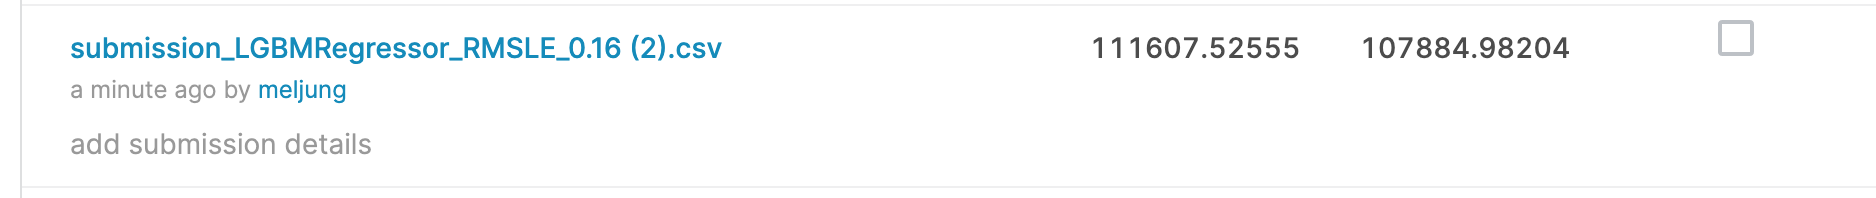